In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import warnings
warnings.filterwarnings('ignore')
import sys
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px

In [ ]:
pd.set_option('display.max_columns',10000)
pd.set_option('display.max_rows',10000)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
df=pd.read_csv('smart_phone.csv')

In [3]:
df.head(2)

,Unnamed: 0,Name,Model_series,Rating,Spec_score,Dual Sim,VoLTE,5G,Vo5G,Ram,...,with Punch Hole,H px,V px,Processor_,Processor_series,No _of_Rear,No _of_Front,Primary_rear_camera,Primary_front_camera,Number_of_core
0,0,Samsung Galaxy F14 5G,F,4.65,68,1,1,1,0,4.0,...,0,2408,1080,exynos,1330.0,2,1,50.0,13.0,8
1,1,Samsung Galaxy A11,A,4.20,63,1,1,0,0,2.0,...,1,720,1560,snapdragon,450.0,3,1,13.0,8.0,8


In [4]:
df=df.drop(columns = ['Unnamed: 0'],axis='columns')
df.drop(['Android_version','Name','Rating','Spec_score','Dual Sim','Water Drop Notch','with Punch Hole'],axis=1,inplace=True)
df['Processor_']=df['Processor_'].replace('sc9863a','unisoc')
df=df[~df.Processor_.isin(['octa','other'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 1369
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model_series          1364 non-null   object 
 1   VoLTE                 1364 non-null   int64  
 2   5G                    1364 non-null   int64  
 3   Vo5G                  1364 non-null   int64  
 4   Ram                   1364 non-null   float64
 5   Battery               1364 non-null   int64  
 6   Display               1364 non-null   float64
 7   Foldable Display      1364 non-null   int64  
 8   Dual Display          1364 non-null   int64  
 9   External_Memory       903 non-null    float64
 10  Price                 1364 non-null   int64  
 11  company               1364 non-null   object 
 12  Inbuilt_memory        1346 non-null   float64
 13  fast_charging         1280 non-null   float64
 14  H px                  1364 non-null   int64  
 15  V px                  1364

### missing value in inbuilt memory and fast charging and processor series

In [6]:
#removing outliear
df=df[df.Battery<7000]
df.Price=np.log(df.Price)

In [7]:
df.External_Memory.fillna(0,inplace=True)
fast_c=df.groupby('company')['fast_charging'].agg(lambda x: stats.mode(x)).apply(lambda x : x[0]).to_dict()
for i in fast_c:
    df.loc[df.company==i,'fast_charging']=df.loc[df.company==i,'fast_charging'].fillna(fast_c[i])
df=df.dropna()

In [8]:
# convert small company in other
temp=df.company.value_counts().reset_index()
l=temp[temp['count']<15]['company'].to_list()
df.company.replace(l,'other',inplace=True)

In [9]:
# add new column  PPI
df['PPI']=round(np.sqrt(df['V px']**2+df['H px']**2)/df.Display)
df=df.drop(['V px','H px','Display'],axis=1)

In [10]:
col=df.columns.to_list()
n_col=['Battery','Price','fast_charging','Primary_rear_camera','Primary_front_camera','PPI']
for r in n_col:
    col.remove(r)

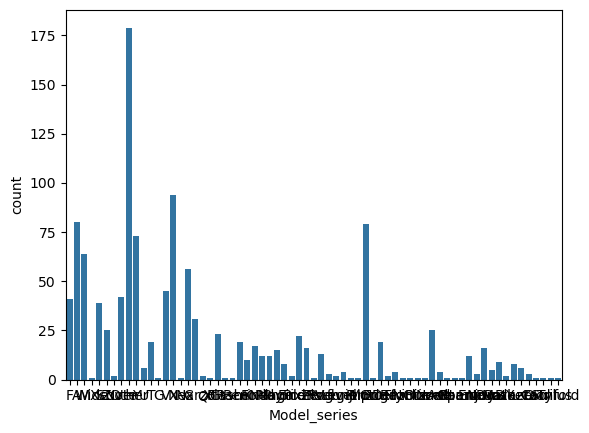

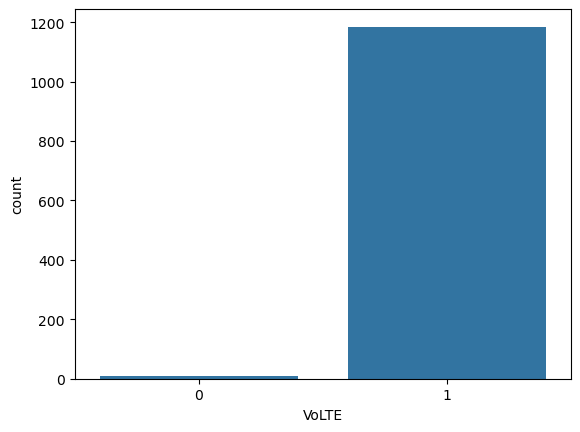

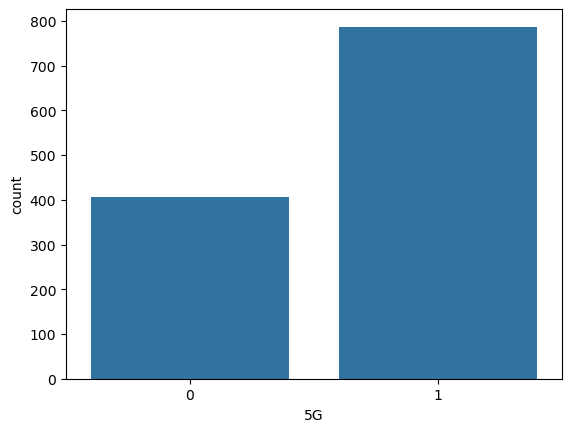

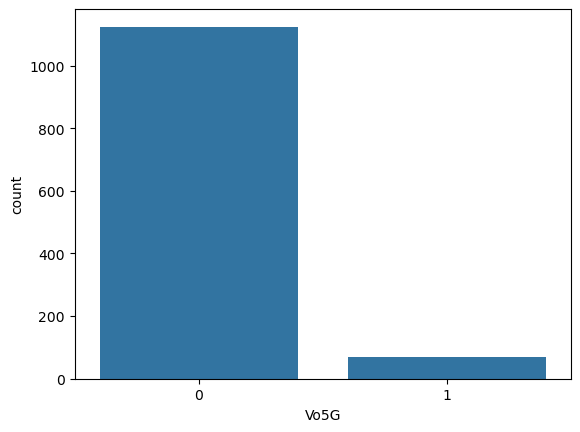

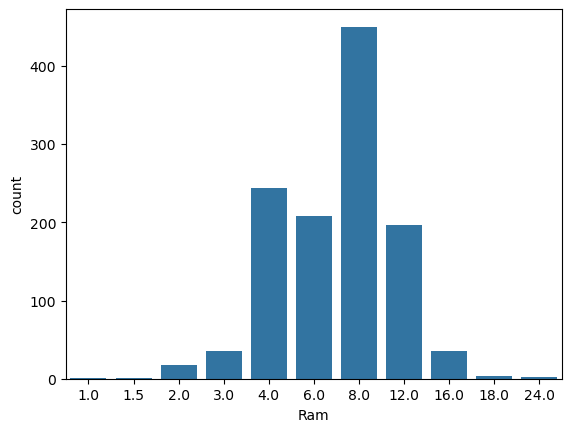

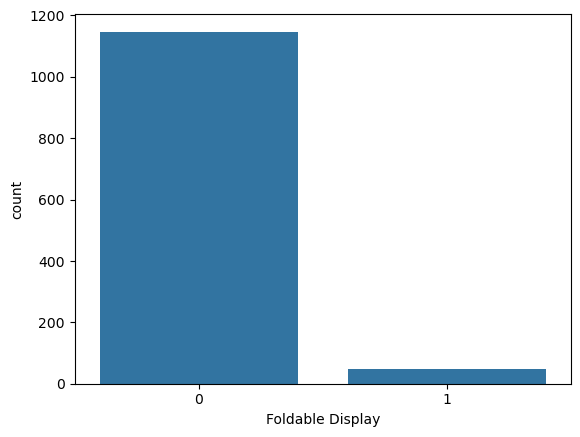

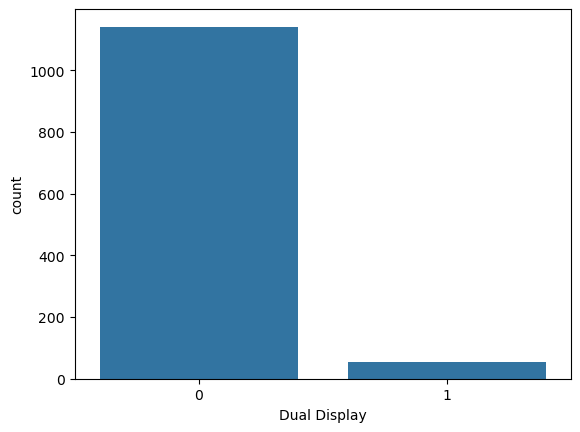

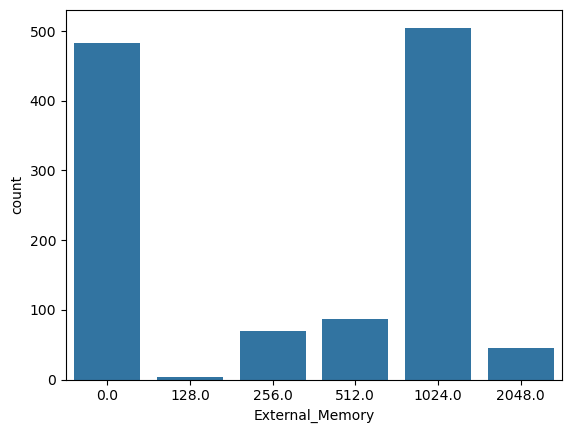

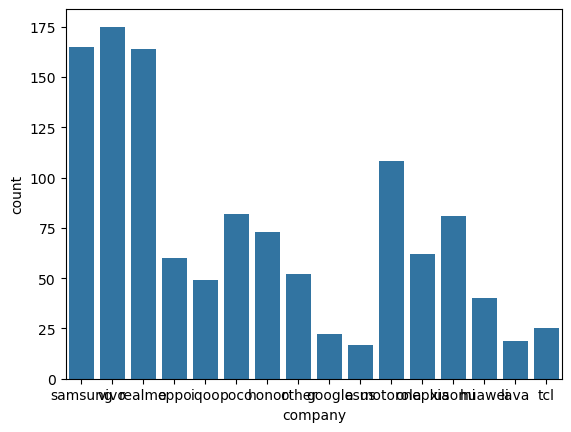

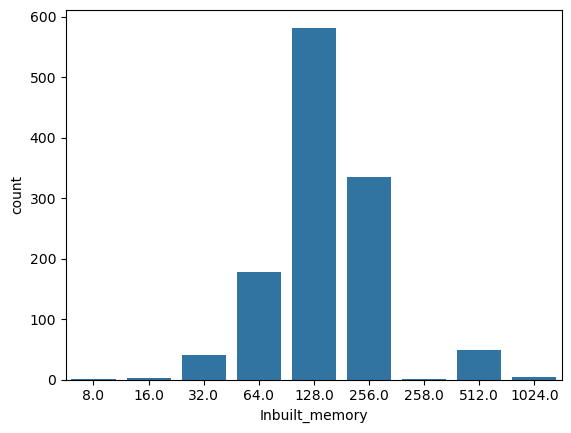

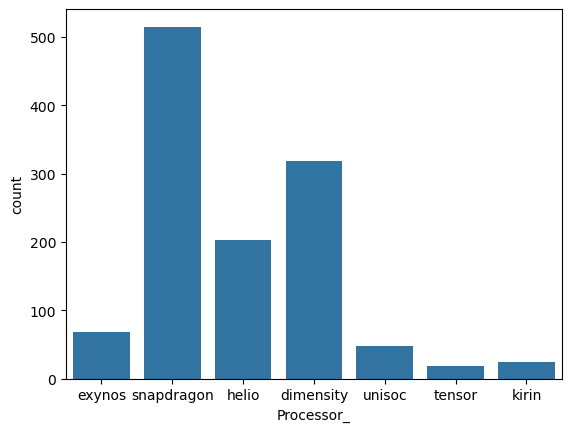

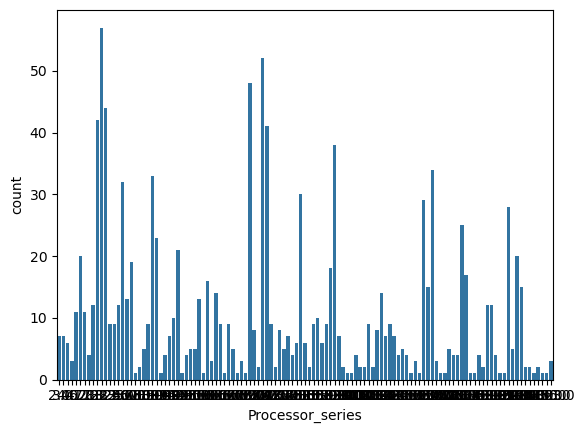

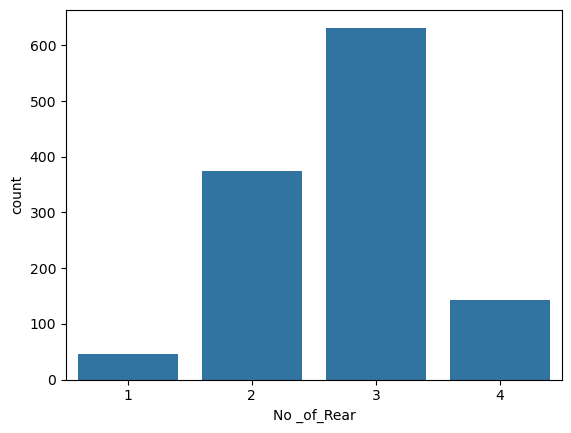

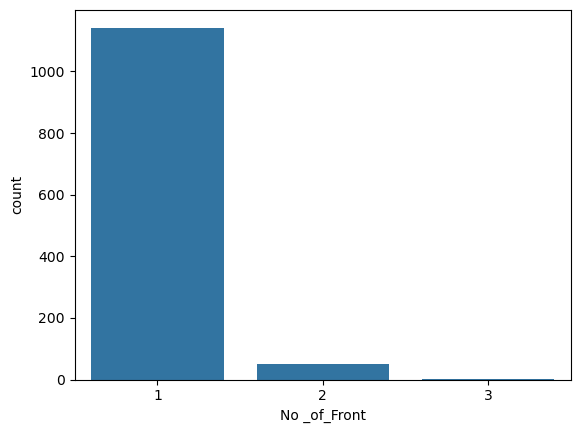

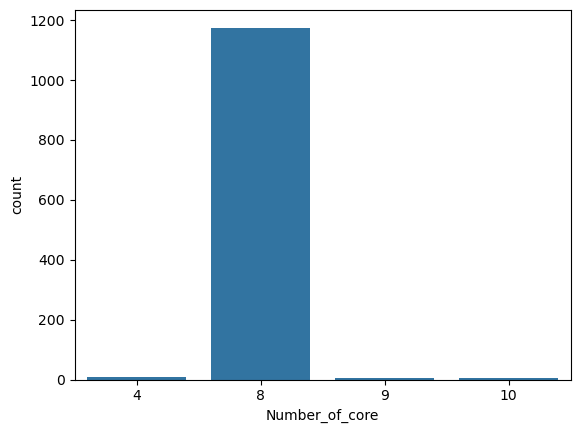

In [11]:
for i in col:
    sns.countplot(df,x=i)
    plt.show()
# Most of phones have dual sim
# all most have volte
# 70 % phone has 5g
# 5 % phone has vo5g
# Most of having 8 GB ram
# Most of phones have 128 GB and 256 GB
# 50% comes with sanpdragon
# 60% of phones have triple rear camera
# 80% of phones come with a single front camera
# Processers come with 8-core

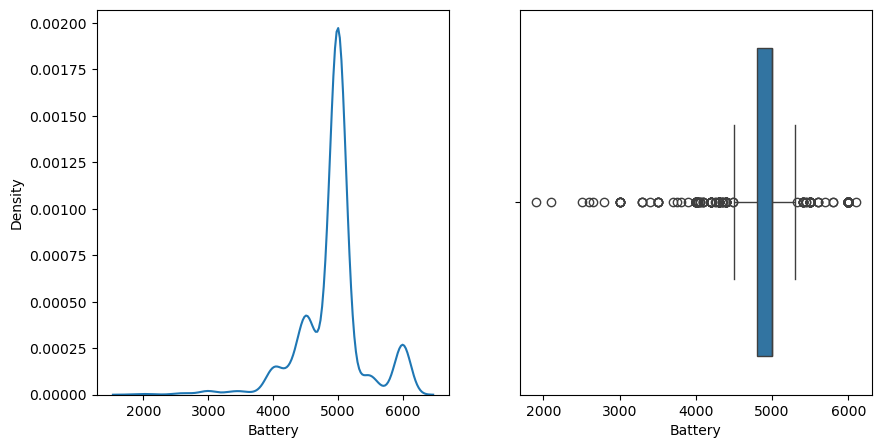

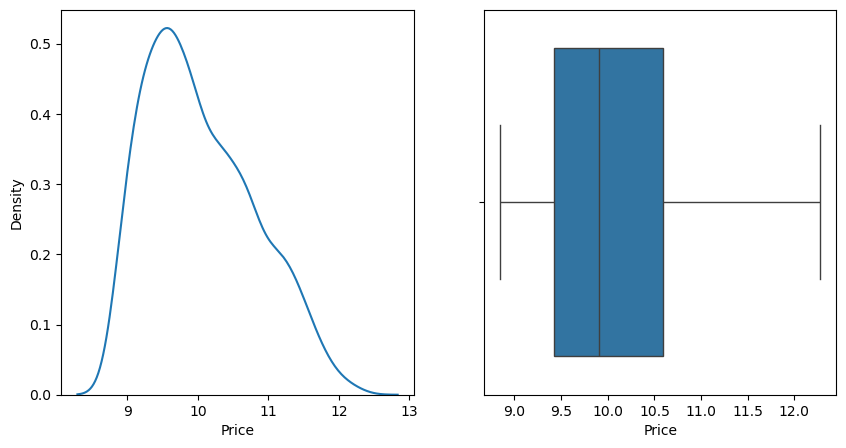

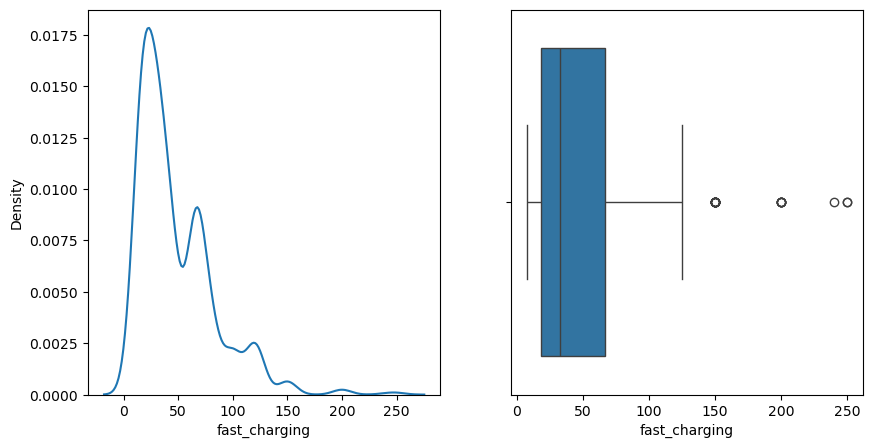

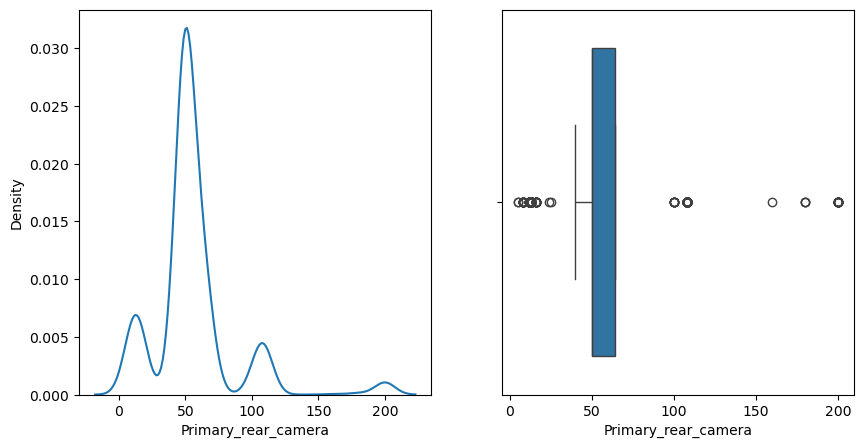

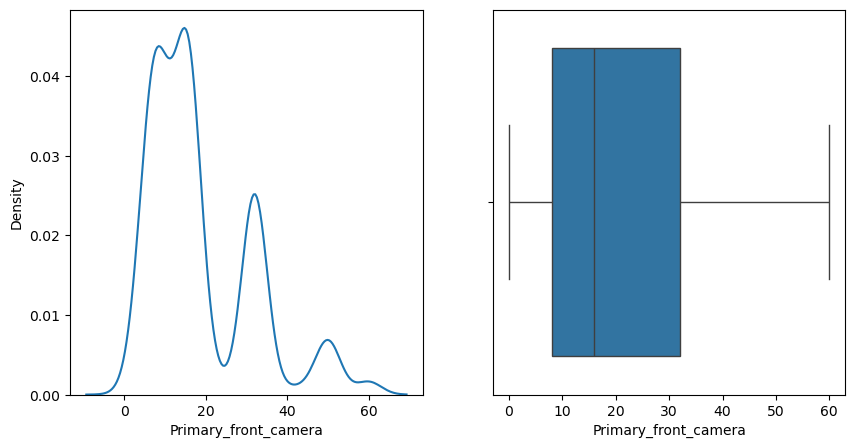

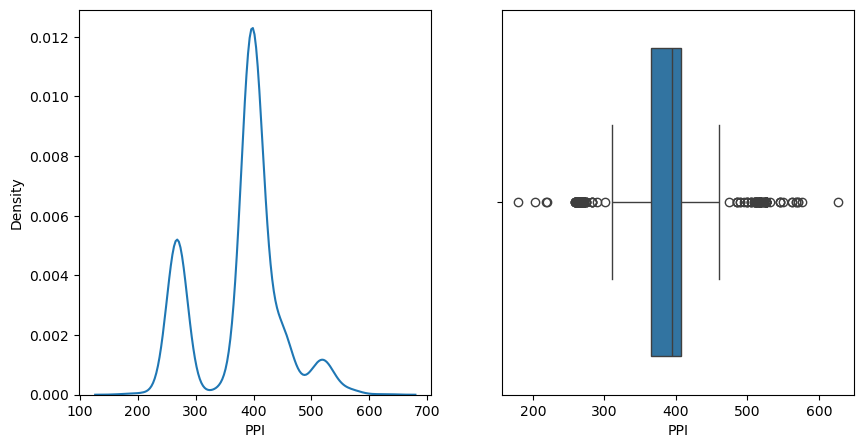

In [12]:
for i in n_col:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df,x=i)
    plt.subplot(1,2,2)
    sns.boxplot(df,x=i)
    plt.show()

#Spec score rigth skewness
#price and fast charging lift skewness

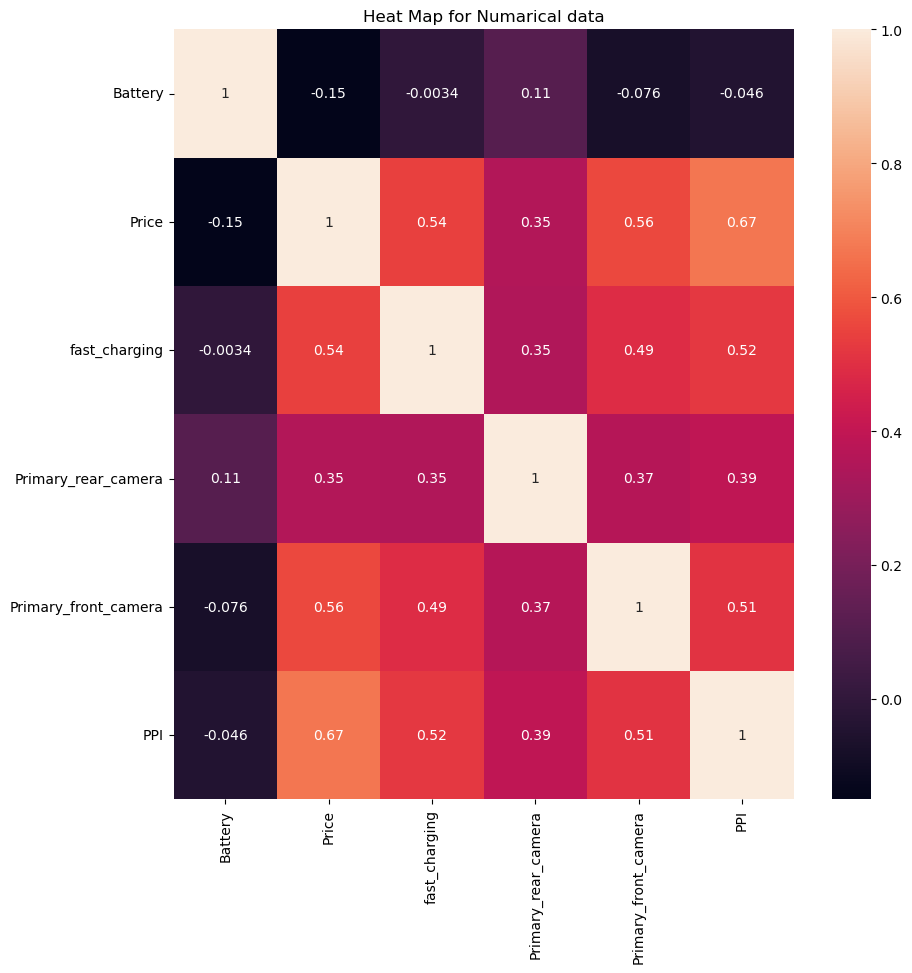

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df[n_col].corr(),annot=True)
plt.title("Heat Map for Numarical data")
plt.show()


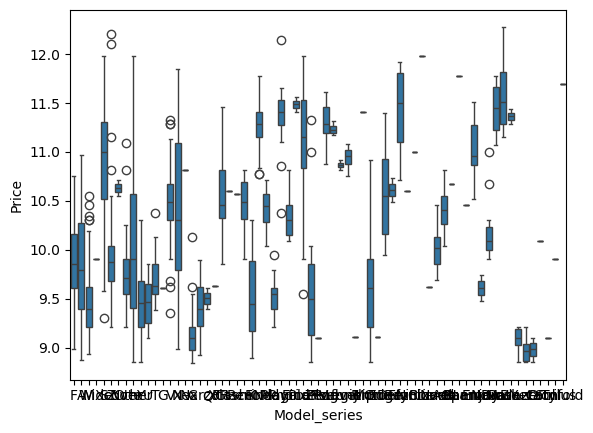

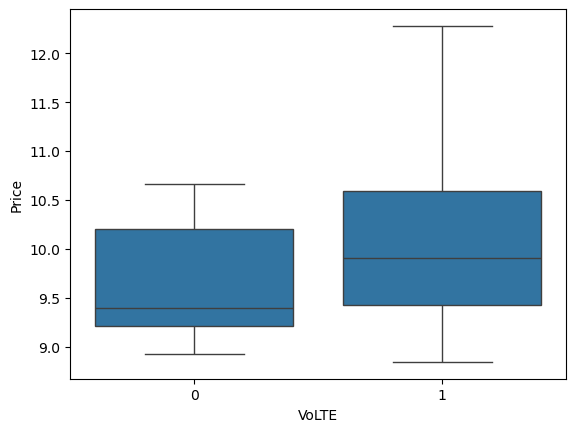

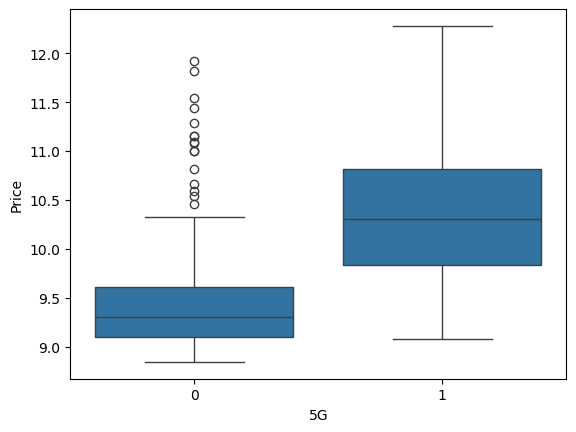

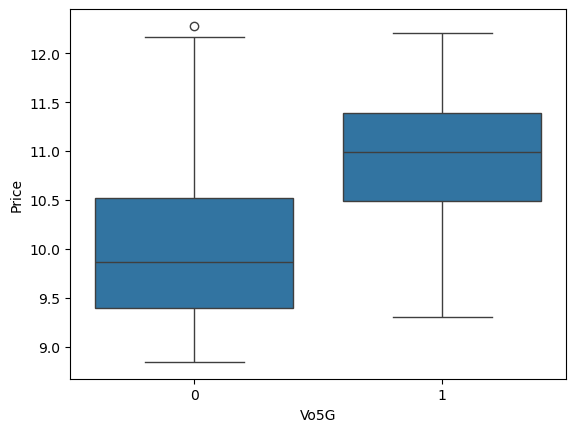

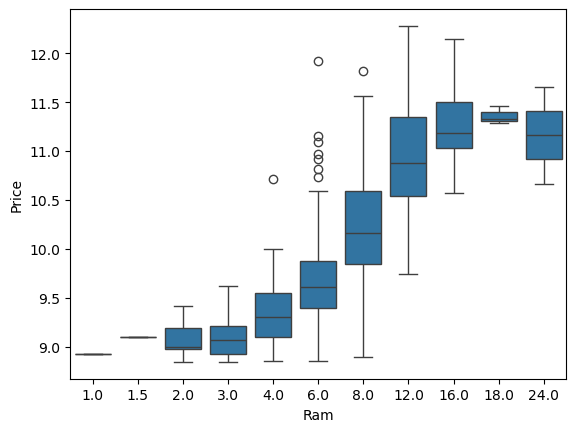

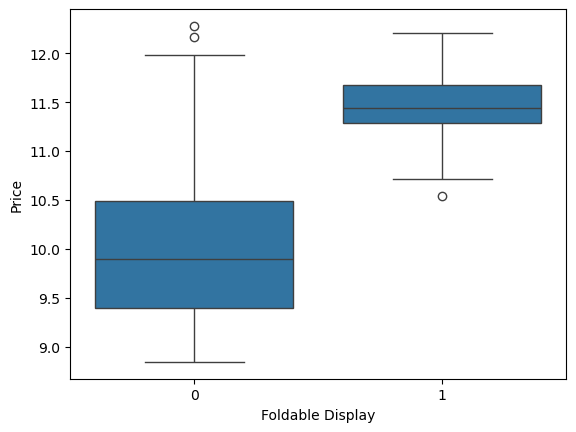

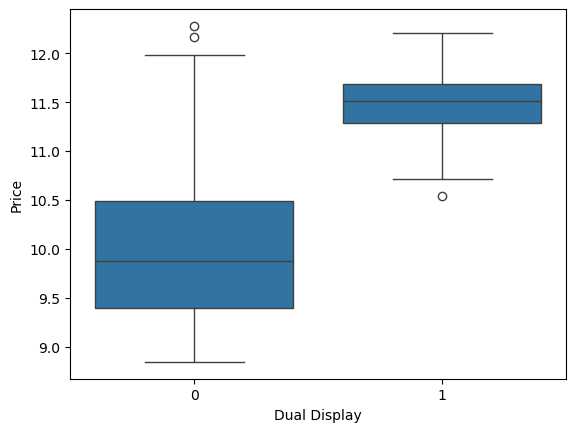

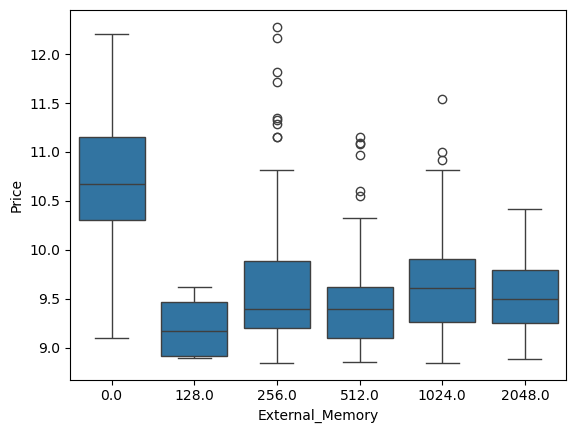

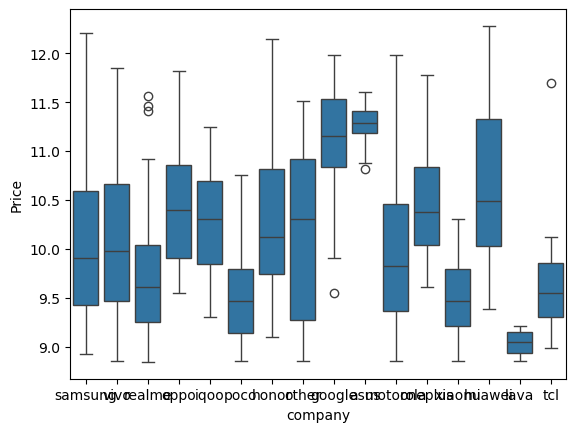

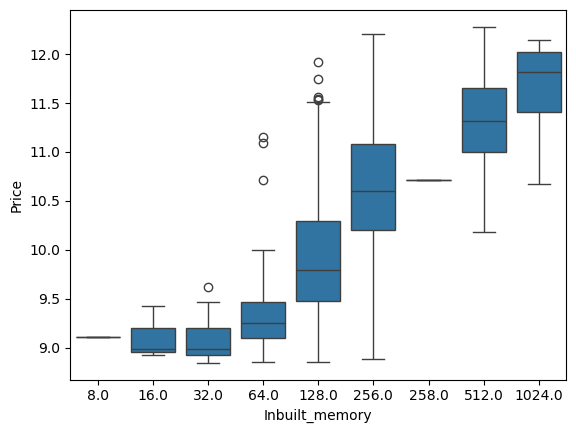

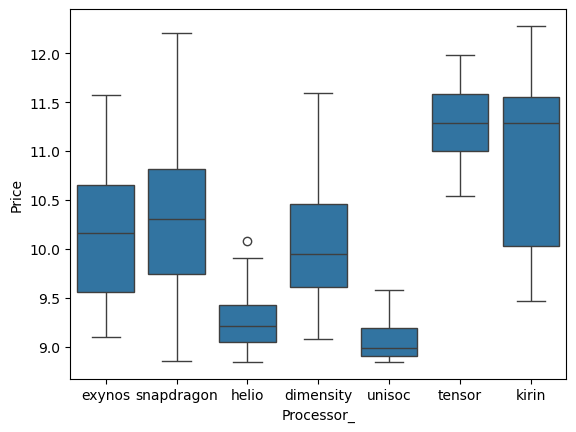

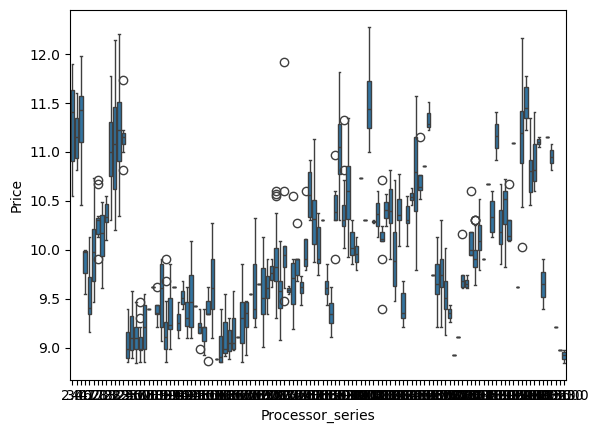

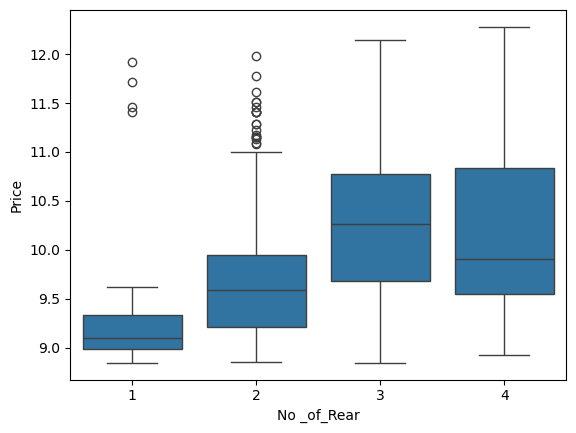

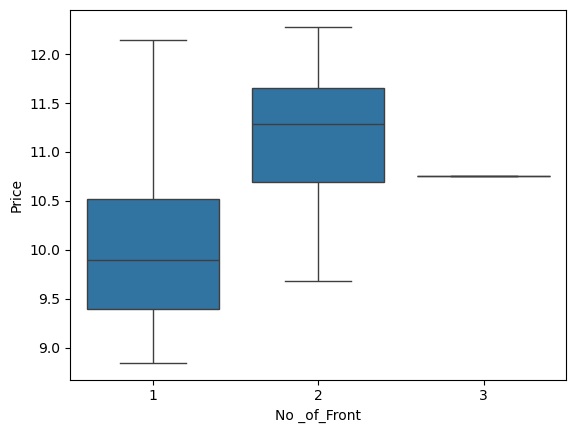

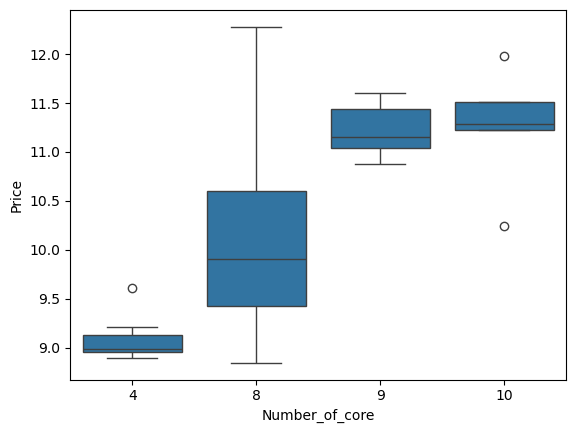

In [14]:
for i in col:
  sns.boxplot(df,y='Price',x=i)
  plt.show()


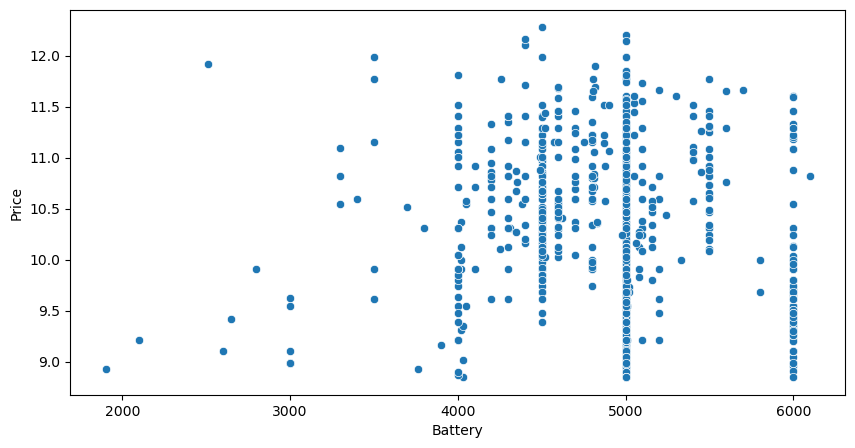

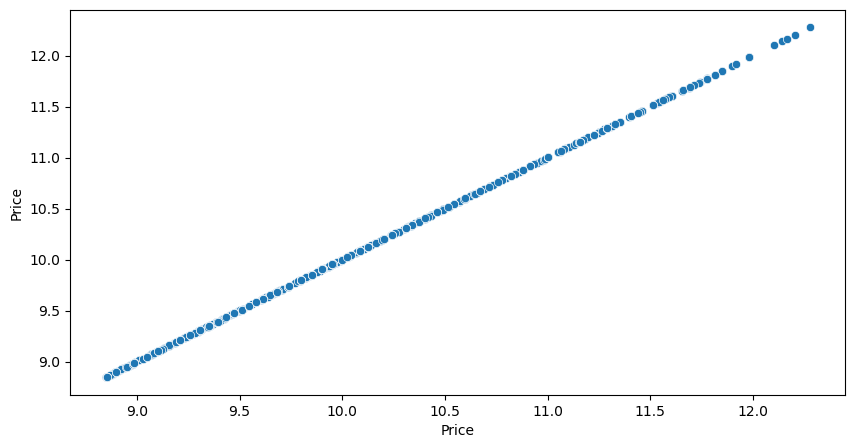

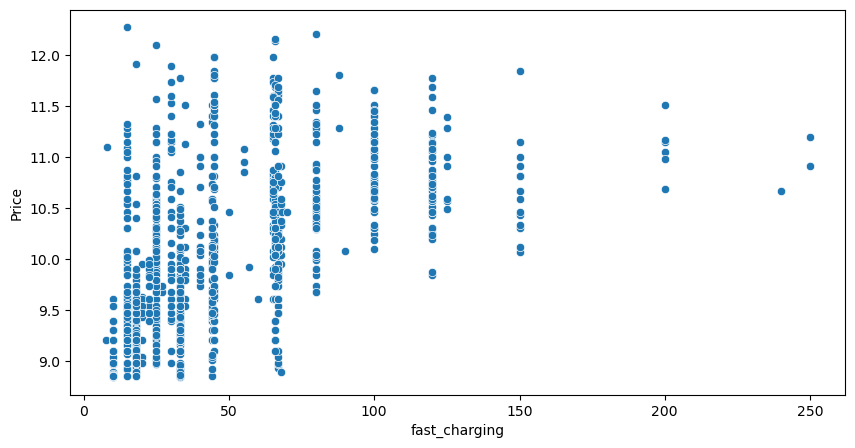

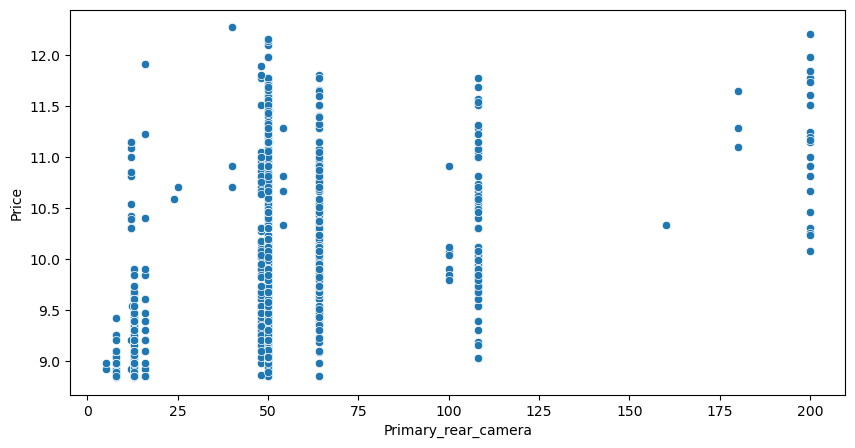

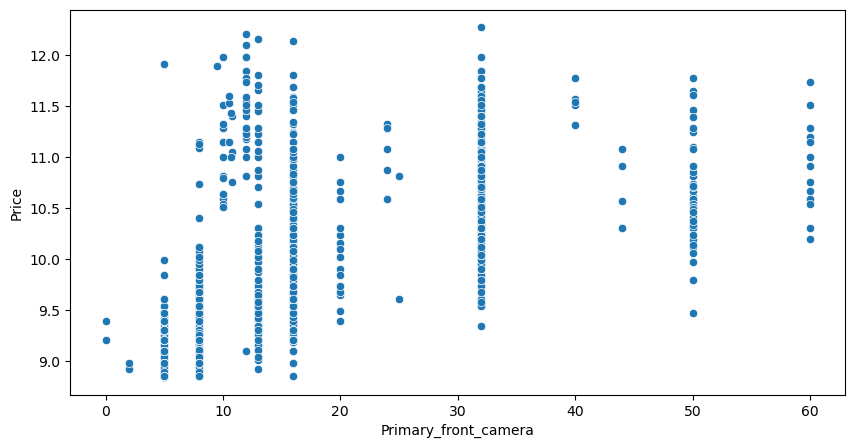

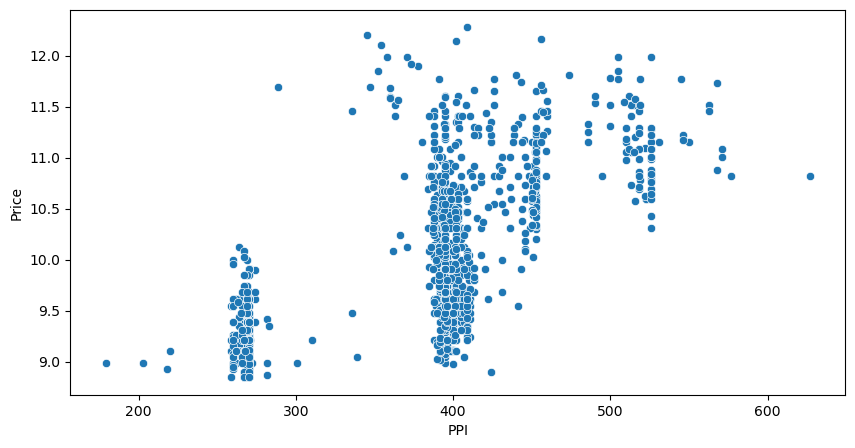

In [15]:
for i in n_col:
    plt.figure(figsize=(10,5))
    sns.scatterplot(df,x=i,y="Price")
    plt.show()


In [16]:

def func(x,y):
    if x=='snapdragon':
        if y < 10:
            return round(round(y)*115+(y-round(y))*500)
        elif y>4000:
            return(y/9)
        else :
            return y
    else:
        return y
    '''if x=='exynos':
        if y > 4000:
            return round(y/10)
        else :
            return y
    elif x=='dimensity':
        if y > 6000:
            return round(y/6.5)
        else :
            return y'''

    '''elif x=='kirin':
        if y > 6000:
            return round(y/5)
        else :
            return y
    elif x=='tensor':
        if y < 10:
            return round(800+y*300)
        else :
            return y
    elif y > 6000:
            return round(y/9)'''

df['Processor_series']=df[['Processor_','Processor_series']].apply(lambda row: func(row['Processor_'],row['Processor_series']),axis=1)

In [17]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
import pickle

In [18]:
x=df.drop('Price',axis=1)
y=df['Price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40,stratify=x.company)

In [19]:
class SparseToDenseTransformer():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

In [20]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                     ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough',)
poly=ColumnTransformer([('poly', PolynomialFeatures(degree=2,include_bias=False,interaction_only=False),slice(-1))])
box=ColumnTransformer([('box cox',PowerTransformer(standardize=True),slice(-1)),
                      ])
STDT=SparseToDenseTransformer()

In [85]:
pipe=Pipeline([('tranformetion',ct),('stdt',STDT),('poly',poly),('box',box)])
x1=pipe.fit_transform(x_train)

In [48]:
st=StandardScaler()
y1=st.fit_transform(np.log(y_train.values.reshape(-1, 1)))

In [49]:
xt1=pipe.transform(x_test)
yt1=st.fit_transform(np.log(y_test.values.reshape(-1, 1)))

In [50]:
print(x_train.shape)
print(y_train.shape)
print(x1.shape)
print(y1.shape)

(936, 20)
(936,)
(936, 5459)
(936, 1)


PCAR


In [51]:
pca=PCA()
pca.fit(x1)

PCA()

In [52]:
a=pd.DataFrame(pca.explained_variance_ratio_ ,columns=['v_ratio'])
a['cumsum']=a['v_ratio'].cumsum()

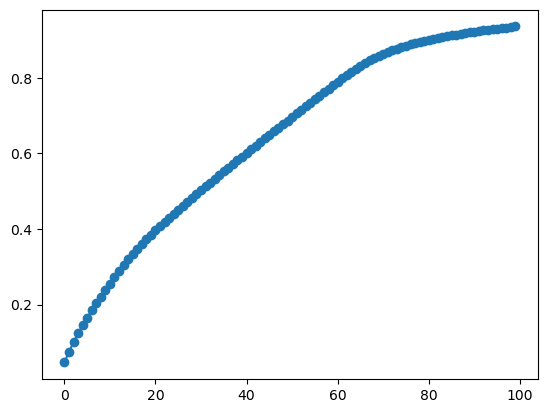

In [53]:
plt.plot(a.index[:100],a['cumsum'][:100],marker='o')

In [54]:
pca=PCA(n_components=100)
pcx1=pca.fit_transform(x1)
pcxt1=pca.transform(xt1)

In [55]:
Ll=Lasso(alpha=0.055,fit_intercept=True)
rl=Ridge(alpha=1,fit_intercept=False)
rl.fit(pcx1,y1)
rl.score(pcx1,y1)

0.9207783883823697

In [56]:
rl.score(pcxt1,yt1)

0.8964441903217076

In [57]:
adj_r2=1-((1-rl.score(pcx1,y1))*(pcx1.shape[0]-1)/(pcx1.shape[0]-pcx1.shape[1]-1))
adj_r2

0.9112907702245696

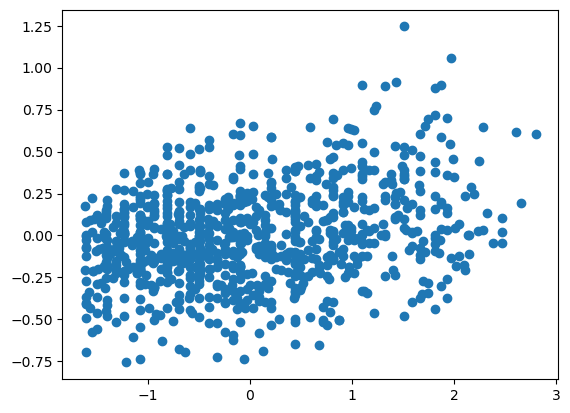

In [58]:
res=y1-rl.predict(pcx1).reshape(-1,1)
plt.scatter(y1,res)

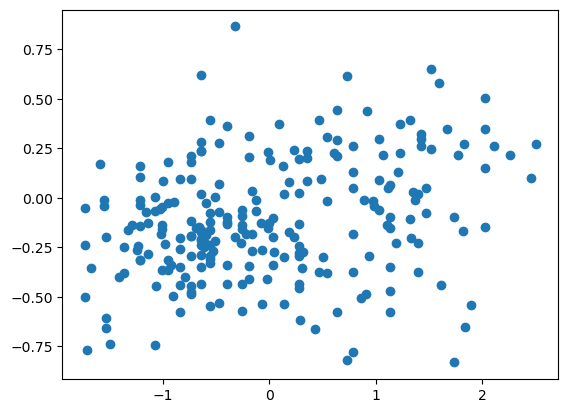

In [59]:
res=yt1-rl.predict(pcxt1).reshape(-1,1)
plt.scatter(yt1,res)

PLSr

In [60]:

class SparseToDenseTransformer():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                     ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough',)
poly=ColumnTransformer([('poly', PolynomialFeatures(degree=2,include_bias=False,interaction_only=False),slice(-1))])
box=ColumnTransformer([('box cox',PowerTransformer(standardize=True),slice(-1)),
                      ])
STDT=SparseToDenseTransformer()


In [61]:
pipe=Pipeline([('tranformetion',ct),('stdt',STDT),('poly',poly),('box',box)])
x1=pipe.fit_transform(x_train)
y1=y_ft.fit_transform(np.array(y_train).reshape(-1,1))
xt1=pipe.transform(x_test)
yt1=y_ft.transform(np.array(y_test).reshape(-1,1))

In [62]:
plsr=PLSRegression(n_components=17)
plsr.fit(x1,y_train)
pl1=plsr.transform(x1)
pl2=plsr.transform(xt1)

In [63]:
pl1.shape

(936, 17)

In [64]:
new=LinearRegression().fit(pl1,y1)
new.fit(pl1,y1)
new.score(pl1,y1)

0.9590846070282824

In [65]:
new.score(pl2,yt1)

0.9216238462107376

In [66]:
adj_r2=1-((1-new.score(pl1,y1))*(pl1.shape[0]-1)/(pl1.shape[0]-pl1.shape[1]-1))
adj_r2

0.9583269145658432

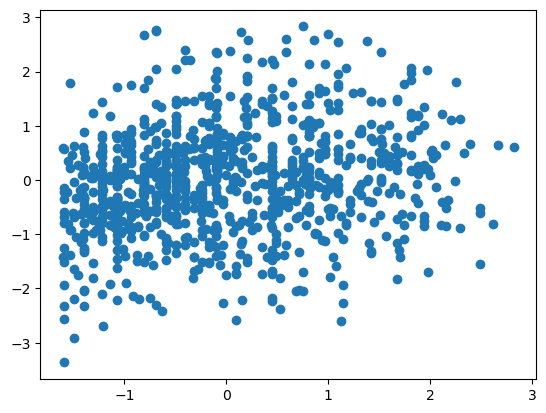

,0,Price
695,-0.680567,-3.364556


In [67]:
res=y1-new.predict(pl1)
res=pd.DataFrame(res)
res['Price']=st.fit_transform(res.values.reshape(-1,1)).reshape(-1)
plt.scatter(y1,res['Price'])
plt.show()
res[(res.Price<-3) | (res.Price>3)]

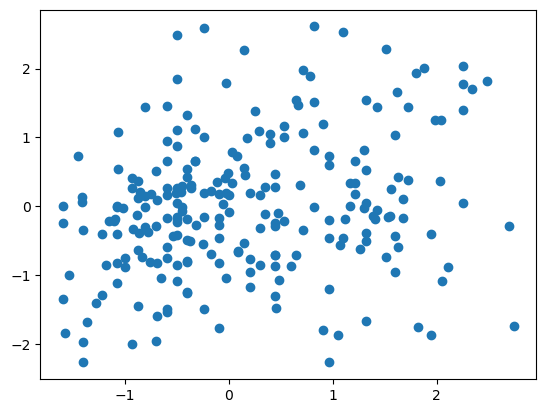

,0,Price


In [68]:
res=yt1-new.predict(pl2)
res=pd.DataFrame(res)
res['Price']=st.fit_transform(res.values.reshape(-1,1)).reshape(-1)
plt.scatter(yt1,res['Price'])
plt.show()
res[(res.Price<-3) | (res.Price>3)]

PLSRegression

In [44]:
from sklearn.base import TransformerMixin, BaseEstimator
class LogStandardScaler(TransformerMixin,BaseEstimator):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, y):
        y_log = np.log1p(y)
        self.scaler.fit(y_log)
        return self

    def transform(self, y):
        y_log = np.log1p(y)
        return self.scaler.transform(y_log)

    def inverse_transform(self, y):
        y_scaled = self.scaler.inverse_transform(y)
        return np.expm1(y_scaled)
y_ft=LogStandardScaler()

In [45]:
x_train=x_train.drop([780,1019,69,1283,43,35,46,1044,73,1229,648,786,1073,58,42,33,981,1034,641])
y_train=y_train.drop([780,1019,69,1283,43,35,46,1044,73,1229,648,786,1073,58,42,33,981,1034,641])
x_test=x_test.drop([54,1052])
y_test=y_test.drop([54,1052])


In [69]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                     ('model',OneHotEncoder(drop='first',handle_unknown='ignore'),['Model_series'])],remainder='passthrough',)
poly=PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)
box=PowerTransformer(standardize=True)
STDT=SparseToDenseTransformer()

making a pipeline for finle model

In [70]:
P=Pipeline([('tranformetion',ct),('stdt',STDT),('poly',poly),('box',box), ('reg',TransformedTargetRegressor(transformer=y_ft,regressor=PLSRegression(n_components=17)))])

In [71]:
model=P.fit(x_train,y_train)

In [72]:
model.score(x_train,y_train)

0.9604572589478602

In [73]:
model.score(x_test,y_test)

0.9220910376266745

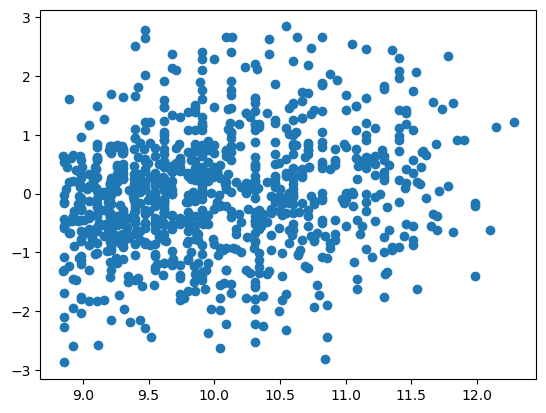

,Price


In [74]:
res=y_train-model.predict(x_train)
res=pd.DataFrame(res)
res['Price']=st.fit_transform(res.values.reshape(-1,1)).reshape(-1)
plt.scatter(y_train,res['Price'])
plt.show()
res[(res.Price<-3) | (res.Price>3)]

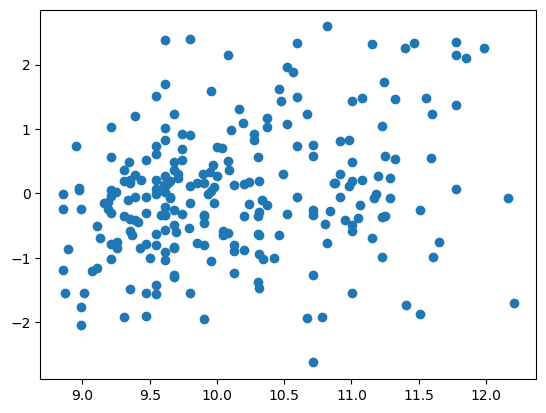

,Price


In [75]:
res=y_test-model.predict(x_test)
res=pd.DataFrame(res)
res['Price']=st.fit_transform(res.values.reshape(-1,1)).reshape(-1)
plt.scatter(y_test,res['Price'])
plt.show()
res[(res.Price<-3) | (res.Price>3)]

In [76]:
transformed_regressor = model.named_steps['reg']
pls_model = transformed_regressor.regressor_

In [77]:
pls_x =pls_model.x_scores_
n_samples, n_features=pls_x.shape

In [78]:
y_pred = model.predict(x_train)
residuals = y_train - y_pred

In [79]:
SSres=residuals.dot(residuals)
DFres=n_samples-n_features-1
MSres=SSres/DFres


In [80]:
SST=(y_train).dot(y_train)-(sum(y_pred))**2/n_samples
DFT=n_samples-1
SSr=(y_train).T.dot(y_train)-(sum(y_pred))**2/n_samples-residuals.T.dot(residuals)
DFr=n_features
MSr=SSr/(n_features)
MSr

31.208471448424543

In [81]:
from tabulate import tabulate
head = ["Source of variation", "Sum of Squares",'Degrees of freedom','Mean Square','F','P value']
data=[['Regression',SSr,DFr,round(MSr,4),round(MSr/MSres,4),round(1-stats.f.cdf(MSr/MSres,DFr,DFres),4)],
      ['Residual',SSres,DFres,round(MSres,4),'',''],
      ['Total',SST,DFT,'','','']]
print('ANOVA Table',f'\n{tabulate(data, headers=head, tablefmt="grid")}')

ANOVA Table 
+-----------------------+------------------+----------------------+---------------+-----------+-----------+
| Source of variation   |   Sum of Squares |   Degrees of freedom | Mean Square   | F         | P value   |
+=======================+==================+======================+===============+===========+===========+
| Regression            |         530.544  |                   17 | 31.2085       | 1360.5531 | 0.0       |
+-----------------------+------------------+----------------------+---------------+-----------+-----------+
| Residual              |          21.0572 |                  918 | 0.0229        |           |           |
+-----------------------+------------------+----------------------+---------------+-----------+-----------+
| Total                 |         551.601  |                  935 |               |           |           |
+-----------------------+------------------+----------------------+---------------+-----------+-----------+


In [82]:
from pandas.plotting import table

se_bita=np.sqrt(np.linalg.inv(pls_x.T.dot(pls_x)).diagonal()*MSres)
bita=pls_model.y_loadings_
t=bita/se_bita
p_value=2*(1-stats.t.cdf(np.abs(t),n_samples-n_features-1))
v=[f'x{i}' for i in range(1,18)]
d=pd.DataFrame({"Term": v,
                "Coefficients" : bita.flatten(),
                'SE of coefficients':se_bita.flatten(),
                'T':t.flatten(),
                'P value':p_value.flatten().round(8)})
print('T Table',f'\n{d}')

T Table 
   Term  Coefficients  SE of coefficients           T       P value
0    x1      0.101924            0.000545  186.938892  0.000000e+00
1    x2      0.041566            0.000949   43.792110  0.000000e+00
2    x3      0.024676            0.000999   24.711951  0.000000e+00
3    x4      0.029218            0.001432   20.406043  0.000000e+00
4    x5      0.024376            0.001273   19.154874  0.000000e+00
5    x6     -0.018510            0.001251  -14.793467  0.000000e+00
6    x7     -0.016304            0.001305  -12.489996  0.000000e+00
7    x8      0.012440            0.001235   10.076032  0.000000e+00
8    x9     -0.011723            0.001470   -7.973453  0.000000e+00
9   x10     -0.015756            0.001719   -9.167183  0.000000e+00
10  x11     -0.009150            0.001310   -6.986905  0.000000e+00
11  x12     -0.010753            0.001666   -6.455230  0.000000e+00
12  x13      0.008046            0.001480    5.435169  7.000000e-08
13  x14      0.006985            0.0013

In [83]:
def confidence_interval(x):
    Y=model.predict(x)
    XTX_inv=np.linalg.inv(pls_x.T.dot(pls_x))
    X_conponet=pipe.transform(x).dot(pls_model.x_weights_).reshape(-1,1)
    lower=Y-1.96*np.sqrt(((X_conponet.T.dot(XTX_inv)).dot(X_conponet)+1)*0.0229)
    upper=Y+1.96*np.sqrt(((X_conponet.T.dot(XTX_inv)).dot(X_conponet)+1)*0.0229)
    return (lower[0,0],upper[0,0])

In [86]:
confidence_interval(x_train.loc[[0]])

(9.050736764714602, 9.656145996966698)

In [87]:
cross_val_score(model,cv=5,X=x_train,y=y_train).mean()

0.8985721579732463

In [88]:
with open('smart_phone_price_with_PLSR.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('pipe.pkl', 'wb') as file:
    pickle.dump(pipe, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(x_train, file)

In [ ]:
x={
        'Dual Sim':[1],'VoLTE':[1],'5G': [1],
        'Vo5G':[1],'Ram':[8],'Battery':[4500],'Foldable Display':[0],
        'company':['google'],'Inbuilt_memory':[128],'fast_charging':[25],
        'Dual Display':[1],'External_Memory':[1024],
        'Water Drop Notch':[1],'with Punch Hole':[0],
        'Processor_':['snapdragon'],'Processor_series':[888],'No _of_Rear':3,'No _of_Front':[1],
        'Primary_rear_camera':[64],'Primary_front_camera':[32],
        'Number_of_core':[8],
        'PPI':[399],
    }
x=pd.DataFrame(x)
x

In [ ]:
a=pickle.load(open('smart_phone_price.pkl','rb'))